# DPU example: Resnet50 using Pybind11

This notebooks shows an example of DPU applications. The application,
as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
For more information, please refer to the 
[Xilinx Vitis AI page](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

In this notebook, we will show how to leverage **Pybind11** to call **C++** DNNDK API.

## 1. Prepare the overlay
We will download the overlay onto the board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The VAI package has been installed onto your board. There are multiple
binaries installed; for example, you can check the current DPU status using
`dexplorer`. You should be able to see reasonable values from the output.

In [2]:
!dexplorer -w

[DPU IP Spec]
IP  Timestamp            : 2020-06-18 12:00:00
DPU Core Count           : 1

[DPU Core Configuration List]
DPU Core                 : #0
DPU Enabled              : Yes
DPU Arch                 : B1600
DPU Target Version       : v1.4.1
DPU Freqency             : 300 MHz
Ram Usage                : Low
DepthwiseConv            : Enabled
DepthwiseConv+Relu6      : Enabled
Conv+Leakyrelu           : Enabled
Conv+Relu6               : Enabled
Channel Augmentation     : Disabled
Average Pool             : Enabled



The compiled quantized model may have different kernel names depending on the DPU architectures.
This piece of information can usually be found when compiling the `*.elf` model file.
The `load_model()` method can automatically parse the kernel name from the 
provided `*.elf` model file.

In [3]:
overlay.load_model("dpu_resnet50_0.elf")

## 2. Run C++ Program

Let's first check the original pictures.

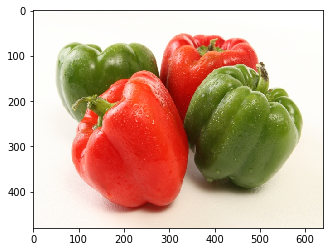

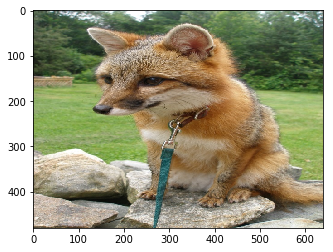

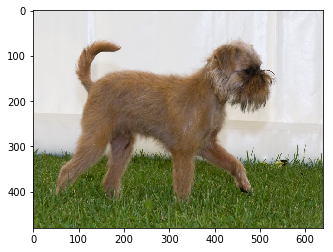

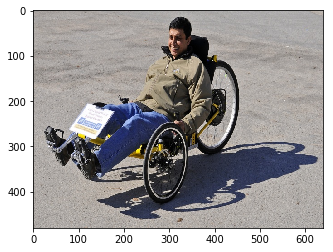

In [4]:
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_folder = "img/"
types = ('*.jpeg', '*.jpg', '*.png', '*.JPEG', '*.JPG', '*.PNG')
image_files = []
for files in types:
    image_files.extend(glob.glob(img_folder + files))
for i in sorted(image_files):
    image = cv2.imread(i)
    _, ax = plt.subplots(1)
    _ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

With the `pynq_dpu` package, users should be able to directly write C++
code in the Jupyter notebook cell, and compile it automatically using
[pybind11](https://pybind11.readthedocs.io/en/stable/). In this notebook
we will show how we leverage this to run DPU programs. 

The magic `%%pybind11` will be added in the next PYNQ release.

Let's first define a few compilation flags. The flags are taken from
the [Makefile](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/resnet50/Makefile)
in the Vitis AI Github.

In [5]:
cflags = "-O2 -Wall -Wpointer-arith -std=c++11 -ffast-math"
ldflags = "-ln2cube -lhineon -lopencv_videoio  -lopencv_imgcodecs " +\
    "-lopencv_highgui -lopencv_imgproc -lopencv_core -lpthread"

We will add the above flags into the following cell along with the magic.

The source code in the cell below is take from the 
[dputils.cpp](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/common/dputils.cpp),
[dputils.h](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/common/dputils.h),
and [main.cc](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/resnet50/src/main.cc)
in the Vitis AI Github. If you compare these programs, you may notice that we 
have made minor changes:

1. We integrated all programs into the same cell. This will ease the linking of the object files.
2. `DPUTask` is a user-defined structure, which is not natively supported by Pybind11 cast types;
so we do explicit type conversions between void pointers and `DPUTask` pointers.

The following cell will compile the C++ code into a shared object. **The compilation
can take up to 30 seconds; please be patient.**

In [6]:
%%pybind11 resnet50;{cflags};{ldflags}

#include <dirent.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/stat.h>
#include <unistd.h>
#include <cmath>
#include <cstdio>
#include <fstream>
#include <iomanip>
#include <iostream>
#include <queue>
#include <string>
#include <vector>
#include <opencv2/opencv.hpp>
#include <dnndk/dnndk.h>
#include <opencv2/opencv.hpp>
#include <dnndk/n2cube.h>

using namespace std;
using namespace cv;

#define N2CUBE_SUCCESS 0
#define USE_NEON_OPT
#define RESNET50_WORKLOAD (7.71f)
#define KERNEL_RESNET50 "resnet50_0"
#define INPUT_NODE      "conv1"
#define OUTPUT_NODE     "fc1000"

int dpuSetInputImageWithScale(void* task_v, const char* nodeName, 
                              const cv::Mat &image, float *mean, 
                              float scale, int idx){
    int value;
    int8_t *inputAddr;
    unsigned char *resized_data;
    cv::Mat newImage;
    float scaleFix;
    int height, width, channel;
    DPUTask* task = (DPUTask*)task_v;
    height = dpuGetInputTensorHeight(task, nodeName, idx);
    width = dpuGetInputTensorWidth(task, nodeName, idx);
    channel = dpuGetInputTensorChannel(task, nodeName, idx);

    if (height == image.rows && width == image.cols) {
        newImage = image;
    } else {
        newImage = cv::Mat (height, width, CV_8SC3,
                    (void*)dpuGetInputTensorAddress(task, nodeName, idx));
        cv::resize(image, newImage, newImage.size(), 0, 0, cv::INTER_LINEAR);
    }
    resized_data = newImage.data;

    inputAddr = dpuGetInputTensorAddress(task, nodeName, idx);
    scaleFix = dpuGetInputTensorScale(task, nodeName, idx);

    scaleFix = scaleFix*scale;

    if (newImage.channels() == 1) {
        for (int idx_h=0; idx_h<height; idx_h++) {
            for (int idx_w=0; idx_w<width; idx_w++) {
                for (int idx_c=0; idx_c<channel; idx_c++) {
                    value = *(resized_data+idx_h*width*channel+\
                              idx_w*channel+idx_c);
                    value = (int)((value - *(mean+idx_c)) * scaleFix);
                    inputAddr[idx_h*newImage.cols+idx_w] = (char)value;
                }
            }
        }
    } else {
#ifdef USE_NEON_OPT
        dpuProcessNormalizion(inputAddr, newImage.data, newImage.rows, 
                              newImage.cols, mean, scaleFix, 
                              newImage.step1());
#else
        for (int idx_h=0; idx_h<newImage.rows; idx_h++) {
            for (int idx_w=0; idx_w<newImage.cols; idx_w++) {
                for (int idx_c=0; idx_c<3; idx_c++) {
                    value = (int)((newImage.at<Vec3b>(idx_h, idx_w)[idx_c] -\
                                   mean[idx_c]) * scaleFix);
                    inputAddr[idx_h*newImage.cols*3+idx_w*3+idx_c] = \
                        (char)value;
                }
            }
        }
#endif
    }
    return N2CUBE_SUCCESS;
}


int dpuSetInputImage2(void* task_v, const char* nodeName, 
                      const cv::Mat &image, int idx){
    float mean[3];
    DPUTask* task = (DPUTask*)task_v;
    dpuGetKernelMean(task,mean,image.channels());
    return dpuSetInputImageWithScale(task_v, nodeName, 
                                     image, mean, 1.0f, idx);
}


void ListImages(string const &path, vector<string> &images) {
    images.clear();
    struct dirent *entry;

    struct stat s;
    lstat(path.c_str(), &s);
    if (!S_ISDIR(s.st_mode)) {
        fprintf(stderr, "Error: %s is not a valid directory!\n", 
                path.c_str());
        exit(1);
    }

    DIR *dir = opendir(path.c_str());
    if (dir == nullptr) {
        fprintf(stderr, "Error: Open %s path failed.\n", path.c_str());
        exit(1);
    }

    while ((entry = readdir(dir)) != nullptr) {
        if (entry->d_type == DT_REG || entry->d_type == DT_UNKNOWN) {
            string name = entry->d_name;
            string ext = name.substr(name.find_last_of(".") + 1);
            if ((ext == "JPEG") || (ext == "jpeg") || (ext == "JPG") ||
                (ext == "jpg") || (ext == "PNG") || (ext == "png")) {
                images.push_back(name);
            }
        }
    }

    closedir(dir);
    sort(images.begin(), images.end());
}


void LoadWords(string const &path, vector<string> &kinds) {
    kinds.clear();
    fstream fkinds(path);
    if (fkinds.fail()) {
        fprintf(stderr, "Error : Open %s failed.\n", path.c_str());
        exit(1);
    }
    string kind;
    while (getline(fkinds, kind)) {
        kinds.push_back(kind);
    }

    fkinds.close();
}


void TopK(const float *d, int size, int k, vector<string> &vkinds) {
    assert(d && size > 0 && k > 0);
    priority_queue<pair<float, int>> q;

    for (auto i = 0; i < size; ++i) {
        q.push(pair<float, int>(d[i], i));
    }

    for (auto i = 0; i < k; ++i) {
        pair<float, int> ki = q.top();
        printf("top[%d] prob = %-8f  name = %s\n", i, d[ki.second],
        vkinds[ki.second].c_str());
        q.pop();
    }
}


void runResnet50(void* task_v, string baseImagePath) {
    DPUTask* taskResnet50 = (DPUTask*)task_v;
    vector<string> kinds, images;
    ListImages(baseImagePath, images);
    if (images.size() == 0) {
        cerr << "\nError: No images existing under " << baseImagePath << endl;
        return;
    }

    LoadWords(baseImagePath + "words.txt", kinds);
    if (kinds.size() == 0) {
        cerr << "\nError: No words exist in file words.txt." << endl;
        return;
    }

    int8_t *outAddr = (int8_t *)dpuGetOutputTensorAddress(
        taskResnet50, OUTPUT_NODE);
    int size = dpuGetOutputTensorSize(taskResnet50, OUTPUT_NODE);
    int channel = dpuGetOutputTensorChannel(taskResnet50, OUTPUT_NODE);
    float out_scale = dpuGetOutputTensorScale(taskResnet50, OUTPUT_NODE);
    float *softmax = new float[size];

    for (auto &imageName : images) {
        cout << "\nLoad image : " << imageName << endl;
        Mat image = imread(baseImagePath + imageName);
        dpuSetInputImage2(task_v, INPUT_NODE, image, 0);

        cout << "\nRun DPU Task for ResNet50 ..." << endl;
        dpuRunTask(taskResnet50);

        long long timeProf = dpuGetTaskProfile(taskResnet50);
        cout << "  DPU Task Execution time: " << (timeProf * 1.0f) << "us\n";
        float prof = (RESNET50_WORKLOAD / timeProf) * 1000000.0f;
        cout << "  DPU Task Performance: " << prof << "GOPS\n";

        dpuRunSoftmax(outAddr, softmax, channel, size/channel, out_scale);
        TopK(softmax, channel, 5, kinds);
    }

    delete[] softmax;
}


int run(string baseImagePath) {
    DPUKernel *kernelResnet50;
    DPUTask *taskResnet50;

    dpuOpen();
    kernelResnet50 = dpuLoadKernel(KERNEL_RESNET50);
    taskResnet50 = dpuCreateTask(kernelResnet50, 0);
    runResnet50((void*)taskResnet50, baseImagePath);
    dpuDestroyTask(taskResnet50);
    dpuDestroyKernel(kernelResnet50);

    return 0;
}

Now `resnet50` can be imported as a Python module. 

We leverage the [existing Python package `wurlitzer`](https://github.com/minrk/wurlitzer) so we can capture the 
C++ outputs into the Jupyter notebook. You should be able to see the printout
from the C++ program. 

In [7]:
from wurlitzer import sys_pipes
import resnet50

with sys_pipes():
    resnet50.run(img_folder)


Load image : bellpeppe-994958.JPEG

Run DPU Task for ResNet50 ...
  DPU Task Execution time: 48137us
  DPU Task Performance: 160.168GOPS
top[0] prob = 0.992235  name = bell pepper
top[1] prob = 0.003158  name = acorn squash
top[2] prob = 0.001915  name = cucumber, cuke
top[3] prob = 0.000905  name = zucchini, courgette
top[4] prob = 0.000549  name = strawberry

Load image : greyfox-672194.JPEG

Run DPU Task for ResNet50 ...
  DPU Task Execution time: 48151us
  DPU Task Performance: 160.121GOPS
top[0] prob = 0.512263  name = grey fox, gray fox, Urocyon cinereoargenteus
top[1] prob = 0.398951  name = red fox, Vulpes vulpes
top[2] prob = 0.032748  name = kit fox, Vulpes macrotis
top[3] prob = 0.015469  name = coyote, prairie wolf, brush wolf, Canis latrans
top[4] prob = 0.012047  name = red wolf, maned wolf, Canis rufus, Canis niger

Load image : irishterrier-696543.JPEG

Run DPU Task for ResNet50 ...
  DPU Task Execution time: 48141us
  DPU Task Performance: 160.155GOPS
top[0] prob = 0.

You can try the same program with other values of `img_folder`.
Note that you need:

1. Make sure you have the `words.txt` containing the class names
stored in the same folder.
2. The path specified by `img_folder` has to end with `/`.

Copyright (C) 2020 Xilinx, Inc